You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
import os
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS
from NGD_TK_AS import ParaTrans

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from NGD_TK_AS.ipynb


In [3]:
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Load Experimental data

## select files and channels

In [4]:
cn = 53

NGD2L1DASpara = np.load( 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)
for k in NGD2L1DASpara.files:
    vars()[k] = NGD2L1DASpara[k][()]

pd.DataFrame(para_dict).loc[cn-1]

epsilon         14.217523
gamma        73996.448279
omegastar       44.711774
deltastar        0.285205
tau_y            0.071035
Dmp             17.541824
error            0.093686
Name: 52, dtype: float64

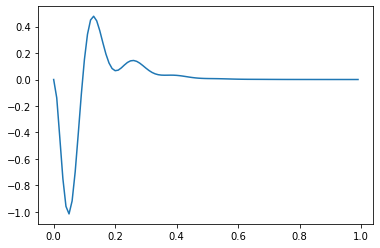

In [5]:
dt = 0.01
T = np.arange(0, 1., dt)
plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]))

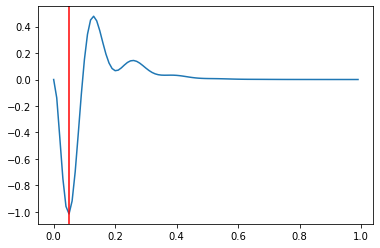

In [6]:
plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]))
plt.axvline(dt*5, c = 'r')

In [7]:
Fc_list = [2]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]


x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [8]:
# from scipy.fft import fft, fftfreq
# c=10
# for x in x_list:
#     yf = fft(x)
#     xf = fftfreq(len(x), dt)
#     plt.plot(xf, np.abs(yf), zorder = c)
#     c-=1
# plt.xlim([0, 5])

In [9]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [10]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534]

In [11]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real Spike

## Plot MI

In [12]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

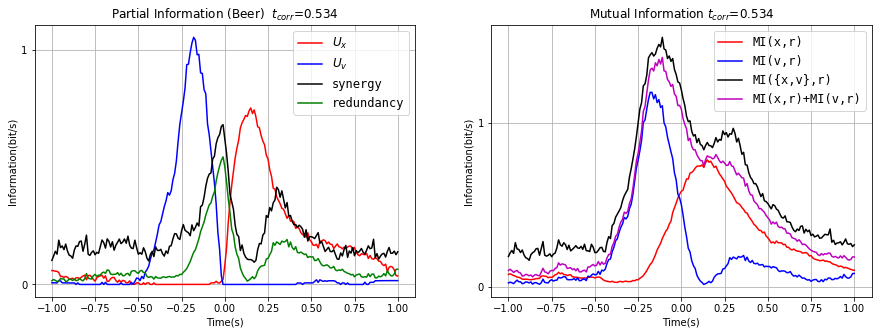

In [13]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

# Fake Spike

## parameters for NGD model and Spike generator

In [14]:
alpha = 20. #1/sec
beta =  1.34
Amp = 23.
g = 23*40.


def NGD_TK(T, alpha, beta, g, Amp, ds=10):
    dt = np.mean(np.diff(T))
    dt = dt/ds
    T = np.arange(0, T[-1]+dt, dt)
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    x=np.zeros(len(T))
    x[0] = 1
    for j in range(len(T)-1):
        dy = dt*(-alpha* y[j]+(x[j]-z[j]))
        dz = dt*(-beta * z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return Amp*y[::ds]/dt

T = np.arange(0,0.8,dt)
TKnd1 = NGD_TK(T, alpha, beta, g, Amp, ds = 1)
# plt.plot(TKnd1)
TKnd50 =  NGD_TK(T, alpha, beta, g, Amp, ds = 50)
# plt.plot(TKnd50)

In [15]:
def NGD_TK_t0(T, alpha, beta, g, Amp, ds=10):
    dt = np.mean(np.diff(T))
    dt = dt/ds
    T = np.arange(0, T[-1]+dt, dt)
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    x=np.zeros(len(T))
    x[0] = 1
    for j in range(len(T)-1):
        dy = dt*(-alpha* y[j-1]+(x[j]-z[j-1]))
        dz = dt*(-beta * z[j-1]+g*y[j-1])
        y[j]=y[j-1]+dy
        z[j]=z[j-1]+dz
    return Amp*y[::ds]/dt

T = np.arange(0,0.8,dt)
TKt01 = NGD_TK_t0(T, alpha, beta, g, Amp, ds = 1)
TKt050 =  NGD_TK_t0(T, alpha, beta, g, Amp, ds = 50)

In [16]:
def NGD_TK_AS(T, epsilon, omegastar, deltastar, Bmp):
    return Bmp*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)

epsilon = (alpha+beta)/2
omegastar = np.sqrt(4*g-(alpha-beta)**2)/2
deltastar = np.arctan((alpha-beta)/np.sqrt(4*g-(alpha-beta)**2))
Bmp = Amp*np.sqrt(4*g)/np.sqrt(4*g-(alpha-beta)**2) #=A/np.cos(deltastar)

TKAS =  NGD_TK_AS(T, epsilon, omegastar, deltastar, Bmp)
# plt.plot(TKAS)

In [17]:
def NGD_TK_AS_wD(T, epsilon, omegastar, deltastar, tau_y, Bmp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = Bmp*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):10]

tau_y = 0.07
TKASwD =  NGD_TK_AS_wD(T, epsilon, omegastar, deltastar, tau_y,Bmp)
# plt.plot( T, TKASwD, label = 'ASwD')

In [18]:
dOmega = 0.1
omega = np.arange(-500,500,dOmega)
H = Amp*(1j*omega+beta) / ( (1j*omega+beta)*(1j*omega+alpha)+g )
lT = np.arange(-0.01,0.8,0.001)
iF_H = np.sum(H[:,np.newaxis]*np.exp(1j*lT[np.newaxis,:]*omega[:,np.newaxis]), axis = 0)*dOmega/(2*np.pi)

# plt.plot(lT, iF_H)
# plt.plot(T, TKAS)

In [19]:
from scipy.optimize import curve_fit

def NGD_TK_ds50(T, alpha, beta, g, Amp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    x=np.zeros(len(T))
    x[0] = 1
    for j in range(len(T)-1):
        dy = dt*(-alpha* y[j]+(x[j]-z[j]))
        dz = dt*(-beta * z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return Amp*y[::50]/dt
target = NGD_TK(T, alpha, beta, g, Amp, ds = 1)
# plt.plot(target)

popt,pcov = curve_fit(NGD_TK_ds50, T, target, p0=[alpha, beta, g,  Amp])
[alpha5021, beta5021, g5021,  Amp5021] = popt
print('alpha:',alpha5021)
print('beta :',beta5021)
print('g    :',g5021)
print('Amp  :',Amp5021)
TKnd50fit1 = NGD_TK_ds50(T, *popt).copy()
# plt.plot(TKnd50fit1)

alpha: 6.6130514091597785
beta : 6.212014403176747
g    : 974.0993824885107
Amp  : 25.715632777998145


In [20]:
T = np.arange(0,0.8,dt)
TKLC = np.zeros_like(T)
Lambda = 0.455
TKLC[2] = 1-Lambda+(Lambda/Dt)
TKLC[3] = -(Lambda/Dt)
TKLC = TKLC
# plt.plot(T, -TKLC*0.05, label = 'LC with delay')
# plt.plot(T, NGD2L_TK_AS(T, *pd.DataFrame(para_dict).loc[cn-1][:-1]), label = 'Real Cell')
# plt.legend()

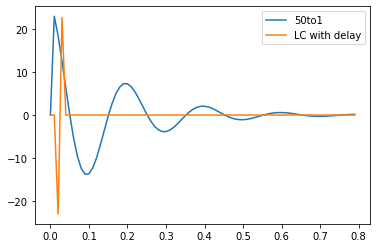

In [21]:
# plt.plot(lT, iF_H, label = 'iF[H]')
# plt.plot( T, TKnd1, label = 'ds == 1')
# plt.plot( T, TKnd50, label = 'ds == 50')
plt.plot( T, TKnd50fit1, label = '50to1')
# plt.plot( T, TKAS, label = 'AS')

# plt.plot( T, TKt050, label = 'nds')
# plt.plot( T, TKASwD, label = 'ASwD')
plt.plot(T, -TKLC*0.5, label = 'LC with delay')
plt.legend()

## Group Delay

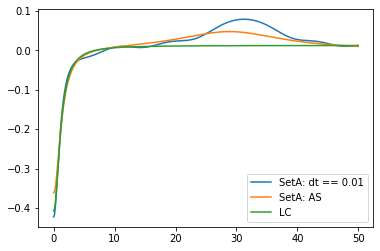

In [39]:
dOmega = 0.1
omega = np.arange(0,100,dOmega)
omega = omega/2
some_dict = {'omega': omega }

F_TK = np.sum(TKnd1[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta, label ='SetA: dt == 0.01')

# F_TK = np.sum(TKnd50[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
# Phi = np.angle(F_TK)
# delta = -angular_gradient(Phi)/dOmega
# plt.plot(omega, delta, label ='SetA: dt == 0.0002')

# F_TK = np.sum(TKnd50fit1[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
# Phi = np.angle(F_TK)
# delta = -angular_gradient(Phi)/dOmega
# some_dict['NGD'] = delta
# plt.plot(omega, delta, label ='SetB: dt == 0.0002')

# F_TK = np.sum(TKASwD[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
# Phi = np.angle(F_TK)
# delta = -angular_gradient(Phi)/dOmega
# plt.plot(omega, delta, label ='SetA: AS with Delay')

H = Amp*(1j*omega+beta) / ( (1j*omega+beta)*(1j*omega+alpha)+g )#/(omega*1j)
Phi = np.angle(H)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta, label ='SetA: AS')

# H = Amp5021*(1j*omega+beta5021) / ( (1j*omega+beta5021)*(1j*omega+alpha5021)+g5021 )#/(omega*1j)
# Phi = np.angle(H)
# delta = -angular_gradient(Phi)/dOmega
# plt.plot(omega, delta, label ='SetB: AS')
# plt.ylabel(r'$\delta$')
# plt.xlabel(r'$\omega$')

# H = (1-Lambda+Lambda*1j*omega)
# Phi = np.angle(H)
# delta = -angular_gradient(Phi)/dOmega
# plt.plot(omega, delta, label ='LCAS')

F_TK = np.sum(TKLC[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*Dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/dOmega
some_dict['LC'] = delta
plt.plot(omega, delta, label ='LC')


# plt.xlim([0, 50])
plt.legend()

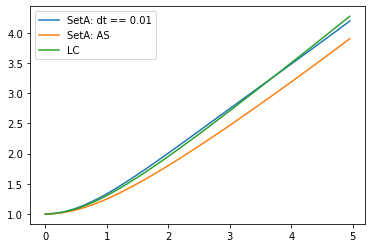

In [40]:
dOmega = 0.1
omega = np.arange(0,10,dOmega)
omega = omega/2
some_dict = {'omega': omega }

F_TK = np.sum(TKnd1[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
G = np.abs(F_TK)
plt.plot(omega, G/G[0], label ='SetA: dt == 0.01')

# F_TK = np.sum(TKASwD[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
# G = np.abs(F_TK)
# plt.plot(omega, G, label ='SetA: AS with Delay')

H = Amp*(1j*omega+beta) / ( (1j*omega+beta)*(1j*omega+alpha)+g )
G = np.abs(H)
plt.plot(omega, G/G[0], label ='SetA: AS')

# H = (1-Lambda+Lambda*1j*omega)
# G = np.abs(H)
# plt.plot(omega, G, label ='LCAS')

F_TK = np.sum(TKLC[np.newaxis,:]*np.exp(-1j*T[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*Dt
G = np.abs(F_TK)
plt.plot(omega, G/G[0], label ='LC')


# plt.xlim([0, 3])
plt.legend()

In [24]:
# import pandas as pd

# data_df = pd.DataFrame(some_dict)

 
# # create and writer pd.DataFrame to excel
# name  = 'delta_of_omega'
# writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
# data_df.to_excel(writer,'page_1',float_format='%.5f') # float_format 控制精度
# writer.save()

In [25]:
y50f1_list = [np.convolve(x, TKnd50fit1, 'full')[:len(x)]*dt  for x in x_list]
y1_list = [np.convolve(x, TKnd1, 'full')[:len(x)]*dt  for x in x_list]
y50_list = [np.convolve(x, TKnd50, 'full')[:len(x)]*dt  for x in x_list]
yAS_list = [np.convolve(x, TKAS, 'full')[:len(x)]*dt  for x in x_list]
yASwD_list = [np.convolve(x, TKASwD, 'full')[:len(x)]*dt  for x in x_list]
# yLCAS_list = [np.convolve(x, iFF_F_TK, 'full')[:len(x)]*dt  for x in x_list]
yLC_list = [np.convolve(x, TKLC, 'full')[:len(x)]*dt  for x in x_list]

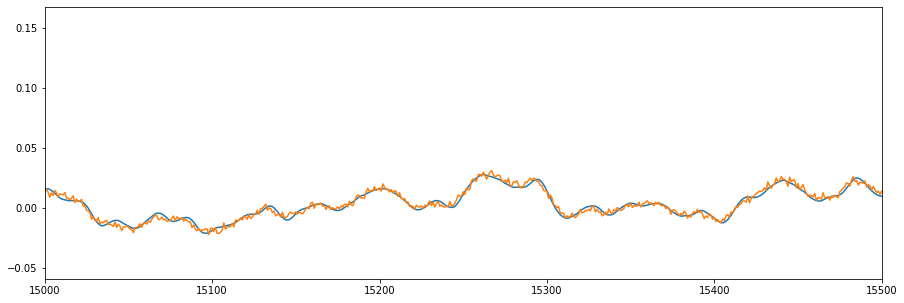

In [26]:
i=0
# plt.plot(x_list[3])
# plt.plot(y1_list[3])
plt.plot(y50f1_list[i]/6)
# plt.plot(y50_list[3])
# plt.plot(yAS_list[3])
# plt.plot(yASwD_list[3])
plt.plot(yLC_list[i])
# plt.plot(yLCAS_list[3]/10)

plt.xlim([15000, 15500])
plt.gcf().set_size_inches(15,5)

## LC model

In [27]:
y_list = yLC_list
#Assign states
# r1state_list = []
# ystate_list = [0]*len(x_list)
# FakeSpike_list = [0]*len(x_list)
# Lambda = 0.45
# for i in range(len(x_list)):
#     r1 = (1-Lambda)*x_list[i]+Lambda*v_list[i]
#     r = NL(r1-np.mean(r1), 0)
#     ratio = sum(r)/T_list[i][-1]/20
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 1)
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
# #     print(np.unique(ystate_list[i]))

Assign states

In [28]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
print(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i].copy()
    r = NL(-y+np.mean(y), 0)
    ratio = sum(r)/T_list[i][-1]/10
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     theta = 1.5*np.std(y) if theta == 0 else theta
#     r = NL(np.mean(y)-y, theta)
#     ratio = sum(r)/sum(rstate_list[i]) if ratio == 0 else ratio
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
#     print(len(FakeSpike_list[i])/sum(rstate_list[i]), len(FakeSpike_list[i])/len(r1))
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
#     counter = 0
#     ty = np.zeros_like(y)
#     for k in range(len(ystate_list[i])):
#         counter += ystate_list[i][k]
#         ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
#     time_ystate_list[i], _ = EqualState(ty, 6)

[0]


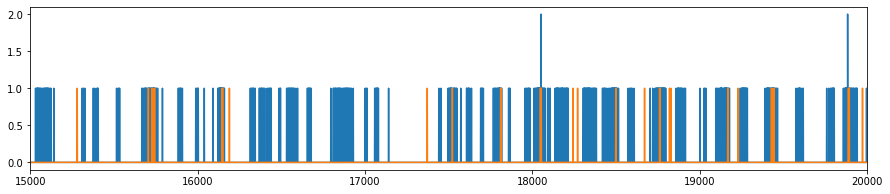

In [29]:
i = 0
plt.plot(ystate_list[i])
plt.plot(rstate_list[i])
plt.xlim([15000, 20000])
plt.gcf().set_size_inches(15,3)

In [30]:
window = [-1,1] # second
LC_Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = LC_Information_list.copy()

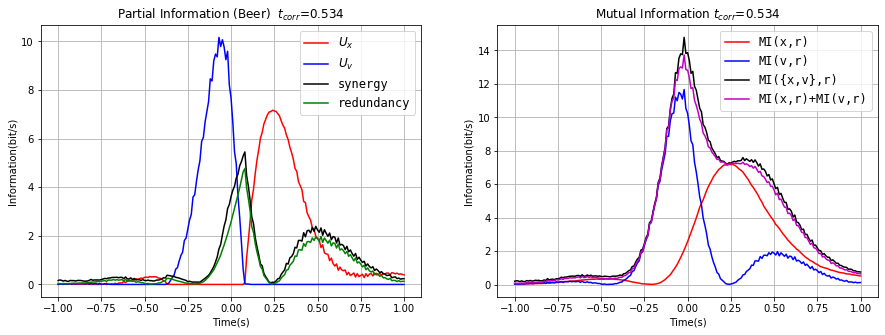

In [31]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

## NGD model

In [32]:
y_list = y50f1_list
#Assign states
# r1state_list = []
# ystate_list = [0]*len(x_list)
# FakeSpike_list = [0]*len(x_list)
# Lambda = 0.45
# for i in range(len(x_list)):
#     r1 = (1-Lambda)*x_list[i]+Lambda*v_list[i]
#     r = NL(r1-np.mean(r1), 0)
#     ratio = sum(r)/T_list[i][-1]/20
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 1)
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
# #     print(np.unique(ystate_list[i]))

Assign states

In [33]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
print(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i].copy()
    r = NL(-y+np.mean(y), 0)
    ratio = sum(r)/T_list[i][-1]/10
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     theta = 1.5*np.std(y) if theta == 0 else theta
#     r = NL(np.mean(y)-y, theta)
#     ratio = sum(r)/sum(rstate_list[i]) if ratio == 0 else ratio
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
#     print(len(FakeSpike_list[i])/sum(rstate_list[i]), len(FakeSpike_list[i])/len(r1))
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
#     counter = 0
#     ty = np.zeros_like(y)
#     for k in range(len(ystate_list[i])):
#         counter += ystate_list[i][k]
#         ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
#     time_ystate_list[i], _ = EqualState(ty, 6)

[0]


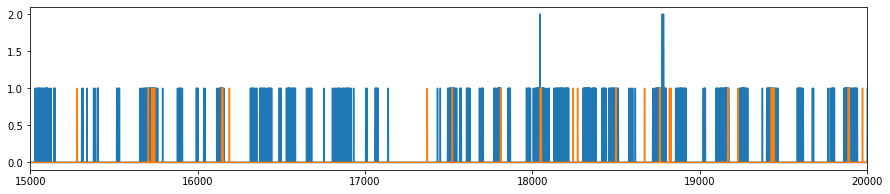

In [34]:
i = 0
plt.plot(ystate_list[i])
plt.plot(rstate_list[i])
plt.xlim([15000, 20000])
plt.gcf().set_size_inches(15,3)

In [35]:
window = [-1,1] # second
NGD_Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, NGD_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = NGD_Information_list.copy()

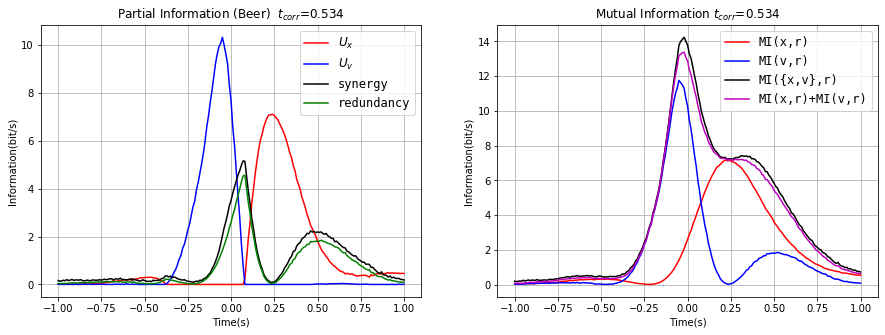

In [36]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

## comparison

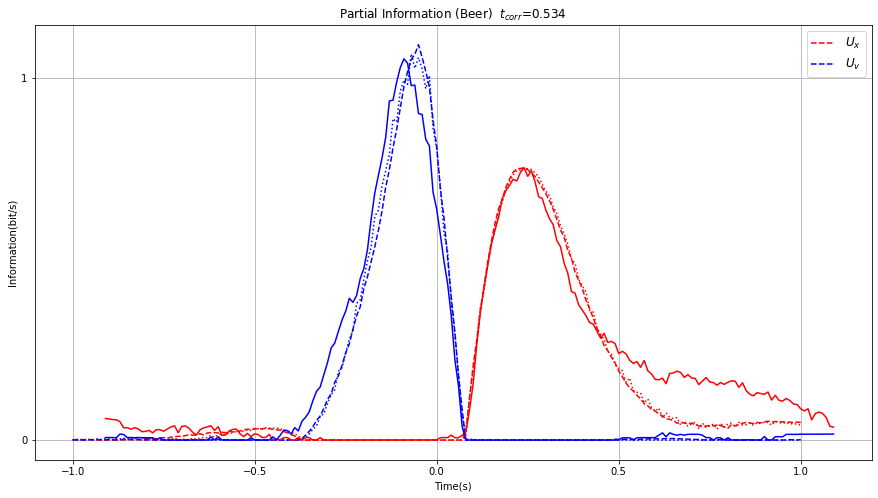

In [38]:
i = 0
DelayStep = 0
Information_list = NGD_Information_list.copy()
Ratio = 1/np.max(NGD_Information_list[i][('Beer','UIx')])*np.max(Real_Information_list[i][('Beer','UIx')])
fig, ax2 = plt.subplots(nrows=1) 
ax2.plot(timeshift + DelayStep*dt, Ratio*Information_list[i][('Beer','UIx')], 'r--')
ax2.plot(timeshift + DelayStep*dt, Ratio*Information_list[i][('Beer','UIv')], 'b--')
# ax2.plot(timeshift+DelayStep*dt,Information_list[i][('Beer','Syn')], 'k--')
# ax2.plot(timeshift+DelayStep*dt,Information_list[i][('Beer','Red')], 'g--')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.grid()

#---------------------------------------------------------------------------------------------------------------------------
Information_list = LC_Information_list.copy()
Ratio = 1/np.max(LC_Information_list[i][('Beer','UIx')])*np.max(Real_Information_list[i][('Beer','UIx')])
ax2.plot(timeshift, Ratio*Information_list[i][('Beer','UIx')], 'r:')
ax2.plot(timeshift, Ratio*Information_list[i][('Beer','UIv')], 'b:')
# ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k:')
# ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g:')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')

ax2.grid()

#---------------------------------------------------------------------------------------------------------------------------
DelayStep = 9
Information_list = Real_Information_list.copy()
ax2.plot(timeshift + DelayStep*dt, Information_list[i][('Beer','UIx')], 'r-')
ax2.plot(timeshift + DelayStep*dt, Information_list[i][('Beer','UIv')], 'b-')
# ax2.plot(timeshift+DelayStep*dt,Information_list[i][('Beer','Syn')], 'k-')
# ax2.plot(timeshift+DelayStep*dt,Information_list[i][('Beer','Red')], 'g-')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()
fig.set_size_inches(15, 8)